# MCT Mock Data Analysis

Comprehensive analysis of the MCT identity circuits in mock_data.

In [ ]:
import sys
sys.path.insert(0, '/Users/egementunca/research-group/sat_revsynth/src')

import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
import networkx as nx

from circuit.circuit import Circuit
from circuit.collection import Collection

MOCK = Path('/Users/egementunca/research-group/sat_revsynth/mock_data')
print('Ready!')

Ready!


## 1. Load Main Collection

In [ ]:
# Load the largest collection (w4g7 has all circuits)
with open(MOCK / 'results_4_7.pickle', 'rb') as f:
    coll = pickle.load(f)

print('Collection loaded!')
print(f'Max width: {coll._max_width}, Max gates: {coll._max_gate_count}')

Collection loaded!
Max width: 4, Max gates: 7


## 2. Circuit Counts by (Width, Gates)

In [ ]:
# Build count matrix
counts = np.zeros((5, 8), dtype=int)

print('=== Circuit Counts ===')
print(f'{"":>4}', end='')
for gc in range(8):
    print(f'g{gc:>7}', end='')
print('\n' + '-'*68)

for w in range(5):
    print(f'w{w}  ', end='')
    for gc in range(8):
        n = len(coll[w][gc])
        counts[w, gc] = n
        print(f'{n:>8}', end='')
    print()

print(f'\nTotal: {counts.sum():,} circuits')

=== Circuit Counts ===
    g      0g      1g      2g      3g      4g      5g      6g      7
--------------------------------------------------------------------
w0         0       0       0       0       0       0       0       0
w1         0       0       1       0       1       0       1       0
w2         0       0       0       0      30      20     356     504
w3         0       0       0       0     144     120   10944   25620
w4         0       0       0       0     528     480  164928  445200

Total: 648,877 circuits


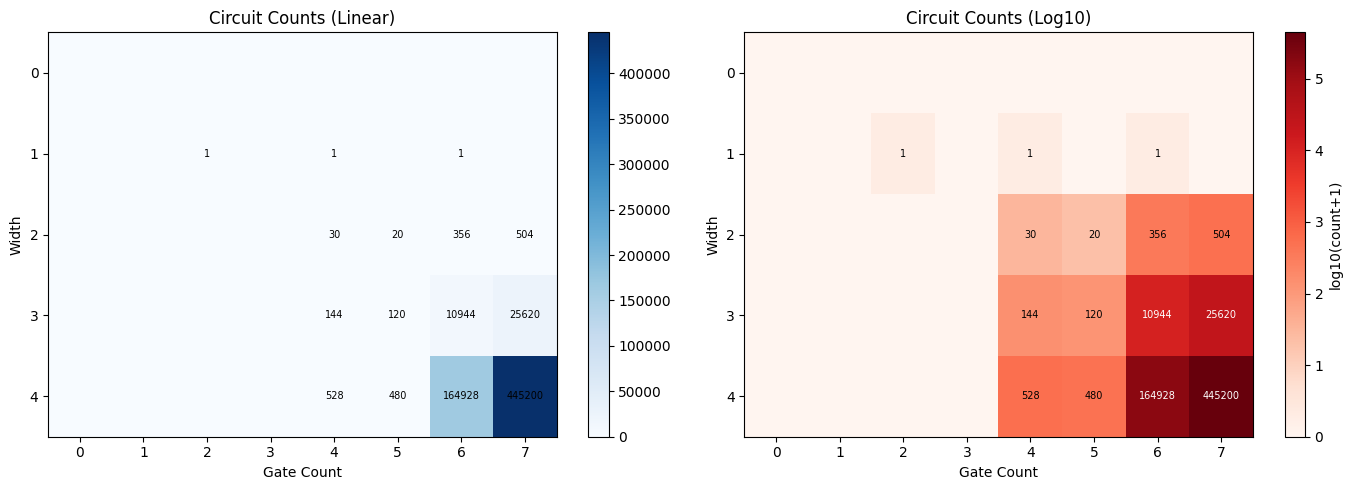

In [ ]:
# Heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
im1 = ax1.imshow(counts, cmap='Blues', aspect='auto')
ax1.set_xlabel('Gate Count')
ax1.set_ylabel('Width')
ax1.set_xticks(range(8)); ax1.set_xticklabels(range(8))
ax1.set_yticks(range(5)); ax1.set_yticklabels(range(5))
ax1.set_title('Circuit Counts (Linear)')
for i in range(5):
    for j in range(8):
        if counts[i,j] > 0:
            ax1.text(j, i, f'{counts[i,j]}', ha='center', va='center', fontsize=7)
plt.colorbar(im1, ax=ax1)

# Log scale
im2 = ax2.imshow(np.log10(counts + 1), cmap='Reds', aspect='auto')
ax2.set_xlabel('Gate Count')
ax2.set_ylabel('Width')
ax2.set_xticks(range(8)); ax2.set_xticklabels(range(8))
ax2.set_yticks(range(5)); ax2.set_yticklabels(range(5))
ax2.set_title('Circuit Counts (Log10)')
for i in range(5):
    for j in range(8):
        if counts[i,j] > 0:
            ax2.text(j, i, f'{counts[i,j]}', ha='center', va='center', fontsize=7, color='white' if counts[i,j]>1000 else 'black')
plt.colorbar(im2, ax=ax2, label='log10(count+1)')

plt.tight_layout()
plt.show()

## 3. Gate Pattern Analysis

In [ ]:
def analyze_gates(circuits):
    """Analyze gate patterns."""
    control_counts = Counter()  # num controls per gate
    target_usage = Counter()    # which wires are targets
    gate_types = Counter()      # (num_controls, target) pattern
    
    for c in circuits:
        for controls, target in c.gates():
            control_counts[len(controls)] += 1
            target_usage[target] += 1
            gate_types[(len(controls), target)] += 1
    
    return control_counts, target_usage, gate_types

# Analyze w4g6 (interesting case)
circuits_w4g6 = list(coll[4][6])
print(f'Analyzing {len(circuits_w4g6)} w4g6 circuits...')

cc, tu, gt = analyze_gates(circuits_w4g6)

print('\nControls per gate:')
for n, count in sorted(cc.items()):
    pct = 100*count/sum(cc.values())
    print(f'  {n} controls: {count:>8} ({pct:.1f}%)')

print('\nTarget wire usage:')
for t, count in sorted(tu.items()):
    pct = 100*count/sum(tu.values())
    print(f'  wire {t}: {count:>8} ({pct:.1f}%)')

Analyzing 164928 w4g6 circuits...

Controls per gate:
  0 controls:   140328 (14.2%)
  1 controls:   386136 (39.0%)
  2 controls:   354240 (35.8%)
  3 controls:   108864 (11.0%)

Target wire usage:
  wire 0:   247392 (25.0%)
  wire 1:   247392 (25.0%)
  wire 2:   247392 (25.0%)
  wire 3:   247392 (25.0%)


## 4. Skeleton Graph Statistics

In [ ]:
def skeleton_stats(circuit):
    """Get skeleton graph statistics."""
    G = nx.DiGraph()
    gates = circuit.gates()
    for i in range(len(gates)):
        G.add_node(i)
    
    last_writer = {}
    for i, (controls, target) in enumerate(gates):
        for c in controls:
            if c in last_writer:
                G.add_edge(last_writer[c], i)
        last_writer[target] = i
    
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G) if G.number_of_nodes() > 1 else 0,
        'max_in': max(dict(G.in_degree()).values()) if G.nodes else 0,
        'max_out': max(dict(G.out_degree()).values()) if G.nodes else 0,
    }

# Analyze skeleton graphs for different (w, gc)
print('=== Skeleton Graph Statistics ===')
for w in [3, 4]:
    for gc in [4, 6]:
        circuits = list(coll[w][gc])[:100]  # Sample
        if not circuits:
            continue
        stats = [skeleton_stats(c) for c in circuits]
        
        avg_edges = np.mean([s['edges'] for s in stats])
        avg_density = np.mean([s['density'] for s in stats])
        max_edges = max(s['edges'] for s in stats)
        
        print(f'w{w}g{gc}: edges={avg_edges:.1f} (max={max_edges}), density={avg_density:.3f}')

=== Skeleton Graph Statistics ===
w3g4: edges=0.6 (max=2), density=0.047
w3g6: edges=0.0 (max=0), density=0.000
w4g4: edges=0.0 (max=0), density=0.000
w4g6: edges=0.0 (max=0), density=0.000


## 5. Sample Circuits Visualization


w3g4: 144 circuits
Gates: [([0], 1), ([0], 1), ([], 2), ([], 2)]


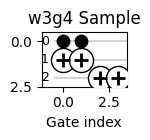


w4g4: 528 circuits
Gates: [([1, 3], 0), ([1, 3], 0), ([], 2), ([], 2)]


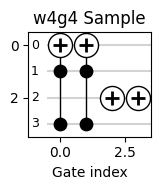


w4g6: 164928 circuits
Gates: [([], 2), ([], 2), ([], 3), ([], 3), ([1], 0), ([1], 0)]


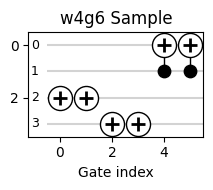

In [ ]:
def draw_mct_circuit(circuit, title=''):
    """Draw MCT circuit."""
    gates = circuit.gates()
    width = circuit.width()
    n = len(gates)
    
    fig, ax = plt.subplots(figsize=(max(8, n*0.5), width*0.5))
    
    # Wires
    for w in range(width):
        ax.hlines(w, -0.5, n-0.5, color='lightgray')
        ax.text(-0.8, w, f'{w}', ha='right', va='center', fontsize=9)
    
    # Gates
    for i, (controls, target) in enumerate(gates):
        all_wires = list(controls) + [target]
        ymin, ymax = min(all_wires), max(all_wires)
        ax.vlines(i, ymin, ymax, color='black', lw=1)
        
        # Target (XOR symbol)
        ax.scatter([i], [target], s=300, c='white', edgecolor='black', zorder=3)
        ax.scatter([i], [target], s=100, marker='+', c='black', zorder=4, linewidths=2)
        
        # Controls (filled dots)
        for c in controls:
            ax.scatter([i], [c], s=80, c='black', zorder=3)
    
    ax.set_xlim(-1.2, n-0.5)
    ax.set_ylim(-0.5, width-0.5)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('Gate index')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

# Draw samples
for w, gc in [(3, 4), (4, 4), (4, 6)]:
    circuits = list(coll[w][gc])
    if circuits:
        print(f'\nw{w}g{gc}: {len(circuits)} circuits')
        c = circuits[0]
        print(f'Gates: {c.gates()}')
        draw_mct_circuit(c, f'w{w}g{gc} Sample')

## 6. Irreducible Circuits

In [ ]:
irr_files = list(MOCK.glob('*irreducible*.pickle'))
print(f'Found {len(irr_files)} irreducible files:')

for f in irr_files:
    size = f.stat().st_size / 1024 / 1024
    with open(f, 'rb') as fp:
        data = pickle.load(fp)
    
    if isinstance(data, list):
        n = len(data)
        print(f'  {f.name}: {n:,} circuits ({size:.1f} MB)')
    else:
        print(f'  {f.name}: Collection ({size:.1f} MB)')

Found 3 irreducible files:
  irreducible_w4g7.pickle: 101,136 circuits (31.8 MB)
  sat_irreducible_w4g6_20251217_182050.pickle: 8,788 circuits (2.4 MB)
  irreducible_w4g6.pickle: 6,672 circuits (1.8 MB)


## 7. Growth Analysis

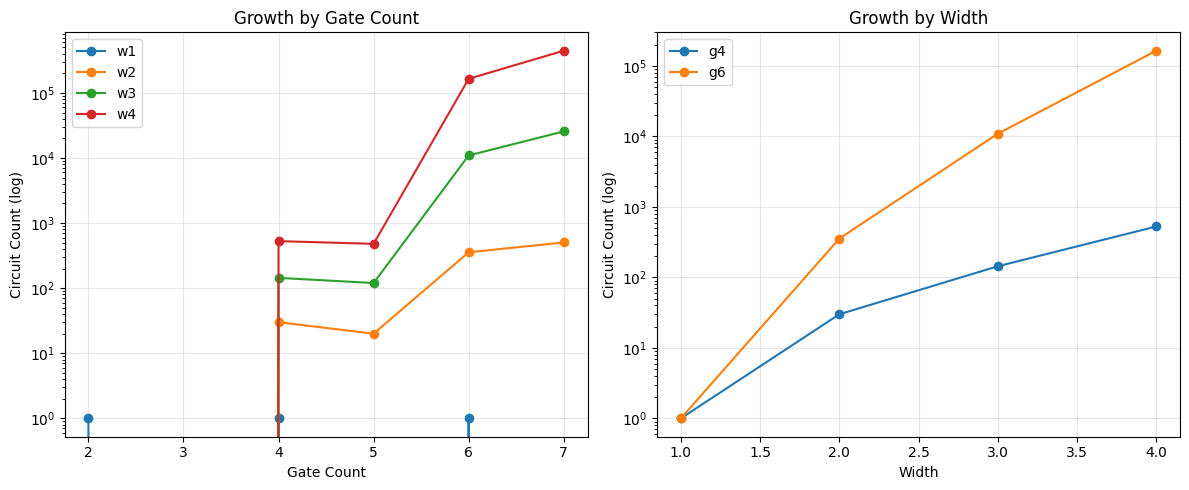

In [ ]:
# Circuit count growth by gate count
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# By width
ax = axes[0]
for w in range(1, 5):
    y = [counts[w, gc] for gc in range(2, 8)]
    ax.semilogy(range(2, 8), y, 'o-', label=f'w{w}')
ax.set_xlabel('Gate Count')
ax.set_ylabel('Circuit Count (log)')
ax.set_title('Growth by Gate Count')
ax.legend()
ax.grid(True, alpha=0.3)

# By gate count
ax = axes[1]
for gc in [4, 6]:
    y = [counts[w, gc] for w in range(1, 5)]
    ax.semilogy(range(1, 5), y, 'o-', label=f'g{gc}')
ax.set_xlabel('Width')
ax.set_ylabel('Circuit Count (log)')
ax.set_title('Growth by Width')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Hardest Circuits

Hardest w4g6 circuits: 100
Type: Circuit

Sample hardest circuit:
  Gates: [([1, 2], 0), ([3], 1), ([0, 3], 2), ([3], 1), ([0, 3], 2), ([1, 2], 0)]


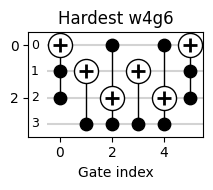


Sample hardest circuit:
  Gates: [([1, 3], 0), ([2], 1), ([0, 2], 3), ([2], 1), ([0, 2], 3), ([1, 3], 0)]


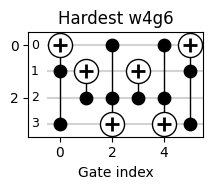


Sample hardest circuit:
  Gates: [([1, 2], 0), ([3], 2), ([0, 3], 1), ([3], 2), ([0, 3], 1), ([1, 2], 0)]


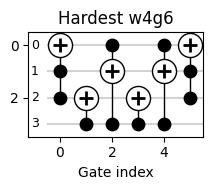


Sample hardest circuit:
  Gates: [([2, 3], 0), ([1], 2), ([0, 1], 3), ([1], 2), ([0, 1], 3), ([2, 3], 0)]


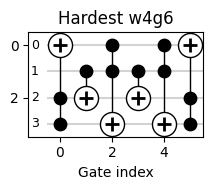


Sample hardest circuit:
  Gates: [([1, 3], 0), ([2], 3), ([0, 2], 1), ([2], 3), ([0, 2], 1), ([1, 3], 0)]


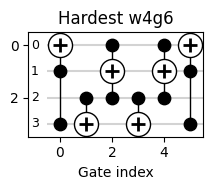


Sample hardest circuit:
  Gates: [([2, 3], 0), ([1], 3), ([0, 1], 2), ([1], 3), ([0, 1], 2), ([2, 3], 0)]


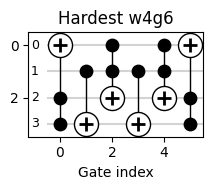


Sample hardest circuit:
  Gates: [([0, 2], 1), ([3], 0), ([1, 3], 2), ([3], 0), ([1, 3], 2), ([0, 2], 1)]


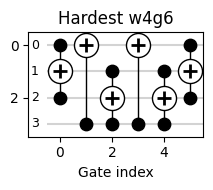


Sample hardest circuit:
  Gates: [([0, 3], 1), ([2], 0), ([1, 2], 3), ([2], 0), ([1, 2], 3), ([0, 3], 1)]


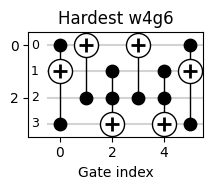


Sample hardest circuit:
  Gates: [([0, 2], 1), ([3], 2), ([1, 3], 0), ([3], 2), ([1, 3], 0), ([0, 2], 1)]


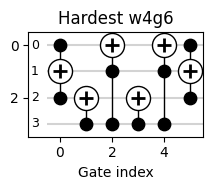


Sample hardest circuit:
  Gates: [([2, 3], 1), ([0], 2), ([0, 1], 3), ([0], 2), ([0, 1], 3), ([2, 3], 1)]


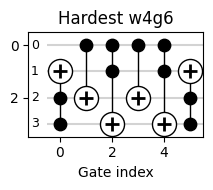


Sample hardest circuit:
  Gates: [([0, 3], 1), ([2], 3), ([1, 2], 0), ([2], 3), ([1, 2], 0), ([0, 3], 1)]


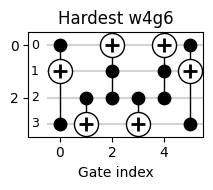


Sample hardest circuit:
  Gates: [([2, 3], 1), ([0], 3), ([0, 1], 2), ([0], 3), ([0, 1], 2), ([2, 3], 1)]


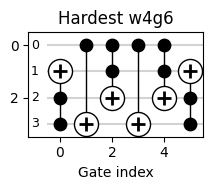


Sample hardest circuit:
  Gates: [([0, 1], 2), ([3], 0), ([2, 3], 1), ([3], 0), ([2, 3], 1), ([0, 1], 2)]


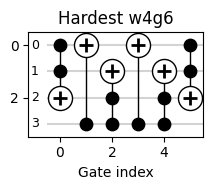


Sample hardest circuit:
  Gates: [([0, 3], 2), ([1], 0), ([1, 2], 3), ([1], 0), ([1, 2], 3), ([0, 3], 2)]


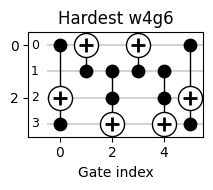


Sample hardest circuit:
  Gates: [([0, 1], 2), ([3], 1), ([2, 3], 0), ([3], 1), ([2, 3], 0), ([0, 1], 2)]


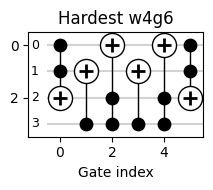


Sample hardest circuit:
  Gates: [([1, 3], 2), ([0], 1), ([0, 2], 3), ([0], 1), ([0, 2], 3), ([1, 3], 2)]


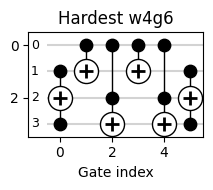


Sample hardest circuit:
  Gates: [([0, 3], 2), ([1], 3), ([1, 2], 0), ([1], 3), ([1, 2], 0), ([0, 3], 2)]


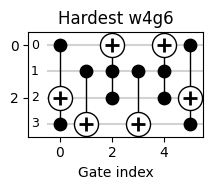


Sample hardest circuit:
  Gates: [([1, 3], 2), ([0], 3), ([0, 2], 1), ([0], 3), ([0, 2], 1), ([1, 3], 2)]


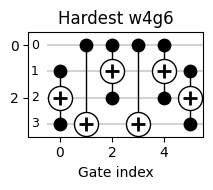


Sample hardest circuit:
  Gates: [([0, 1], 3), ([2], 0), ([2, 3], 1), ([2], 0), ([2, 3], 1), ([0, 1], 3)]


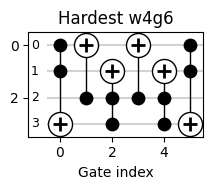


Sample hardest circuit:
  Gates: [([0, 2], 3), ([1], 0), ([1, 3], 2), ([1], 0), ([1, 3], 2), ([0, 2], 3)]


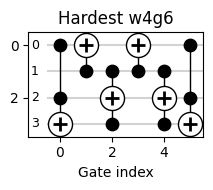


Sample hardest circuit:
  Gates: [([0, 1], 3), ([2], 1), ([2, 3], 0), ([2], 1), ([2, 3], 0), ([0, 1], 3)]


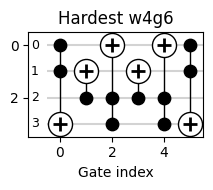


Sample hardest circuit:
  Gates: [([1, 2], 3), ([0], 1), ([0, 3], 2), ([0], 1), ([0, 3], 2), ([1, 2], 3)]


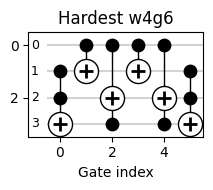


Sample hardest circuit:
  Gates: [([0, 2], 3), ([1], 2), ([1, 3], 0), ([1], 2), ([1, 3], 0), ([0, 2], 3)]


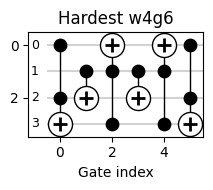


Sample hardest circuit:
  Gates: [([1, 2], 3), ([0], 2), ([0, 3], 1), ([0], 2), ([0, 3], 1), ([1, 2], 3)]


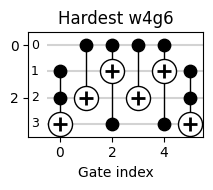


Sample hardest circuit:
  Gates: [([1, 2], 0), ([0, 3], 2), ([3], 1), ([0, 3], 2), ([3], 1), ([1, 2], 0)]


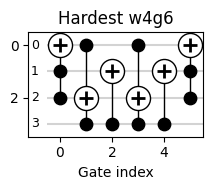


Sample hardest circuit:
  Gates: [([1, 3], 0), ([0, 2], 3), ([2], 1), ([0, 2], 3), ([2], 1), ([1, 3], 0)]


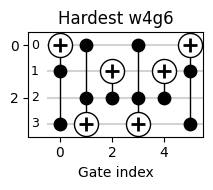


Sample hardest circuit:
  Gates: [([1, 2], 0), ([0, 3], 1), ([3], 2), ([0, 3], 1), ([3], 2), ([1, 2], 0)]


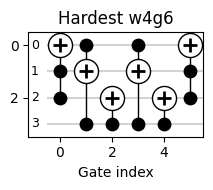


Sample hardest circuit:
  Gates: [([2, 3], 0), ([0, 1], 3), ([1], 2), ([0, 1], 3), ([1], 2), ([2, 3], 0)]


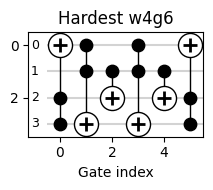


Sample hardest circuit:
  Gates: [([1, 3], 0), ([0, 2], 1), ([2], 3), ([0, 2], 1), ([2], 3), ([1, 3], 0)]


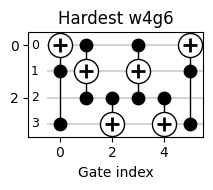


Sample hardest circuit:
  Gates: [([2, 3], 0), ([0, 1], 2), ([1], 3), ([0, 1], 2), ([1], 3), ([2, 3], 0)]


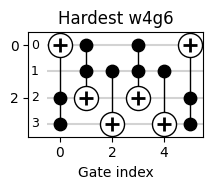


Sample hardest circuit:
  Gates: [([0, 2], 1), ([1, 3], 2), ([3], 0), ([1, 3], 2), ([3], 0), ([0, 2], 1)]


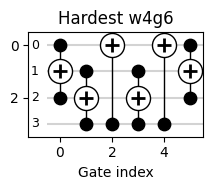


Sample hardest circuit:
  Gates: [([0, 3], 1), ([1, 2], 3), ([2], 0), ([1, 2], 3), ([2], 0), ([0, 3], 1)]


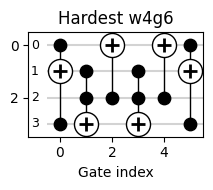


Sample hardest circuit:
  Gates: [([0, 2], 1), ([1, 3], 0), ([3], 2), ([1, 3], 0), ([3], 2), ([0, 2], 1)]


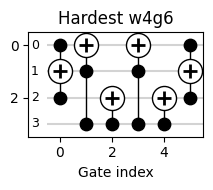


Sample hardest circuit:
  Gates: [([2, 3], 1), ([0, 1], 3), ([0], 2), ([0, 1], 3), ([0], 2), ([2, 3], 1)]


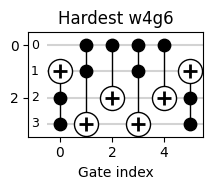


Sample hardest circuit:
  Gates: [([0, 3], 1), ([1, 2], 0), ([2], 3), ([1, 2], 0), ([2], 3), ([0, 3], 1)]


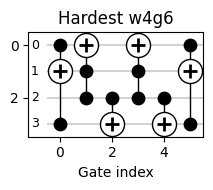


Sample hardest circuit:
  Gates: [([2, 3], 1), ([0, 1], 2), ([0], 3), ([0, 1], 2), ([0], 3), ([2, 3], 1)]


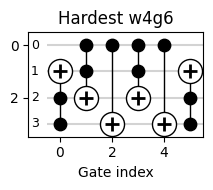


Sample hardest circuit:
  Gates: [([0, 1], 2), ([2, 3], 1), ([3], 0), ([2, 3], 1), ([3], 0), ([0, 1], 2)]


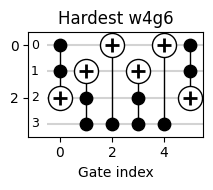


Sample hardest circuit:
  Gates: [([0, 3], 2), ([1, 2], 3), ([1], 0), ([1, 2], 3), ([1], 0), ([0, 3], 2)]


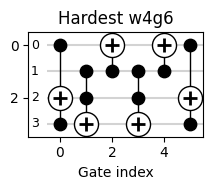


Sample hardest circuit:
  Gates: [([0, 1], 2), ([2, 3], 0), ([3], 1), ([2, 3], 0), ([3], 1), ([0, 1], 2)]


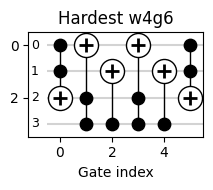


Sample hardest circuit:
  Gates: [([1, 3], 2), ([0, 2], 3), ([0], 1), ([0, 2], 3), ([0], 1), ([1, 3], 2)]


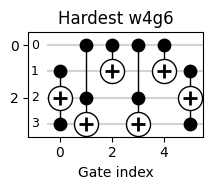


Sample hardest circuit:
  Gates: [([0, 3], 2), ([1, 2], 0), ([1], 3), ([1, 2], 0), ([1], 3), ([0, 3], 2)]


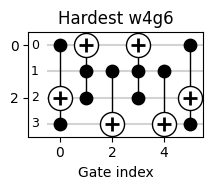


Sample hardest circuit:
  Gates: [([1, 3], 2), ([0, 2], 1), ([0], 3), ([0, 2], 1), ([0], 3), ([1, 3], 2)]


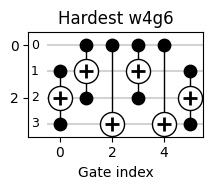


Sample hardest circuit:
  Gates: [([0, 1], 3), ([2, 3], 1), ([2], 0), ([2, 3], 1), ([2], 0), ([0, 1], 3)]


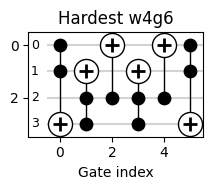


Sample hardest circuit:
  Gates: [([0, 2], 3), ([1, 3], 2), ([1], 0), ([1, 3], 2), ([1], 0), ([0, 2], 3)]


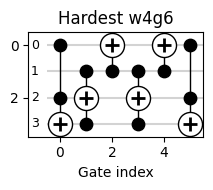


Sample hardest circuit:
  Gates: [([0, 1], 3), ([2, 3], 0), ([2], 1), ([2, 3], 0), ([2], 1), ([0, 1], 3)]


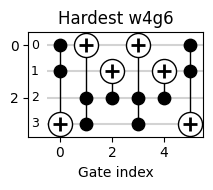


Sample hardest circuit:
  Gates: [([1, 2], 3), ([0, 3], 2), ([0], 1), ([0, 3], 2), ([0], 1), ([1, 2], 3)]


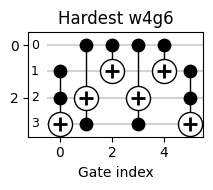


Sample hardest circuit:
  Gates: [([0, 2], 3), ([1, 3], 0), ([1], 2), ([1, 3], 0), ([1], 2), ([0, 2], 3)]


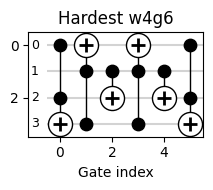


Sample hardest circuit:
  Gates: [([1, 2], 3), ([0, 3], 1), ([0], 2), ([0, 3], 1), ([0], 2), ([1, 2], 3)]


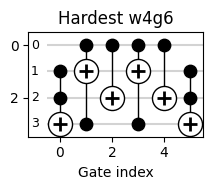


Sample hardest circuit:
  Gates: [([0, 3], 2), ([1], 2), ([0, 1], 3), ([1], 2), ([0, 1], 3), ([0, 3], 2)]


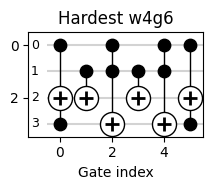


Sample hardest circuit:
  Gates: [([0, 2], 3), ([1], 3), ([0, 1], 2), ([1], 3), ([0, 1], 2), ([0, 2], 3)]


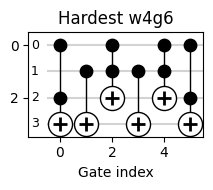

In [ ]:
hardest_path = MOCK / 'hardest_w4g6.pickle'
if hardest_path.exists():
    with open(hardest_path, 'rb') as f:
        hardest = pickle.load(f)
    
    print(f'Hardest w4g6 circuits: {len(hardest)}')
    print(f'Type: {type(hardest[0]).__name__ if hardest else "?"}')
    
    if hardest:
        i = 0
        for c in hardest:
            print(f'\nSample hardest circuit:')
            print(f'  Gates: {c.gates()}')
            draw_mct_circuit(c, 'Hardest w4g6')
            i += 1
            if i >= 50:
                break
else:
    print('hardest_w4g6.pickle not found')

Type: Circuit

Sample hardest circuit:
  Gates: [([], 2), ([2], 0), ([1, 3], 2), ([], 2), ([1, 3], 2), ([2], 0), ([], 0)]


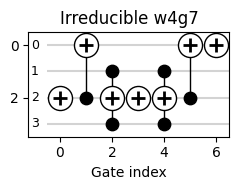


Sample hardest circuit:
  Gates: [([], 3), ([3], 0), ([1, 2], 3), ([], 3), ([1, 2], 3), ([3], 0), ([], 0)]


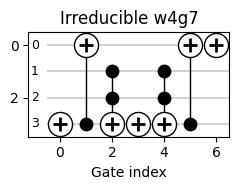


Sample hardest circuit:
  Gates: [([], 1), ([1], 0), ([2, 3], 1), ([], 1), ([2, 3], 1), ([1], 0), ([], 0)]


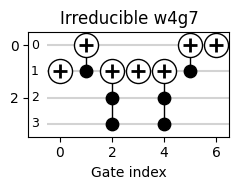


Sample hardest circuit:
  Gates: [([], 2), ([2], 1), ([0, 3], 2), ([], 2), ([0, 3], 2), ([2], 1), ([], 1)]


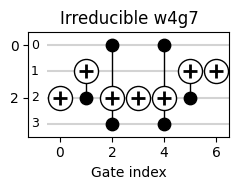


Sample hardest circuit:
  Gates: [([], 3), ([3], 1), ([0, 2], 3), ([], 3), ([0, 2], 3), ([3], 1), ([], 1)]


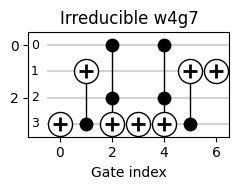


Sample hardest circuit:
  Gates: [([], 0), ([0], 1), ([2, 3], 0), ([], 0), ([2, 3], 0), ([0], 1), ([], 1)]


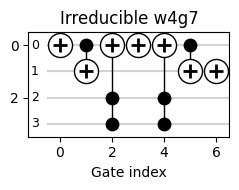


Sample hardest circuit:
  Gates: [([], 1), ([1], 2), ([0, 3], 1), ([], 1), ([0, 3], 1), ([1], 2), ([], 2)]


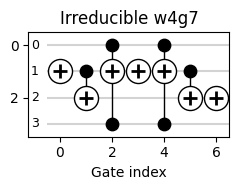


Sample hardest circuit:
  Gates: [([], 3), ([3], 2), ([0, 1], 3), ([], 3), ([0, 1], 3), ([3], 2), ([], 2)]


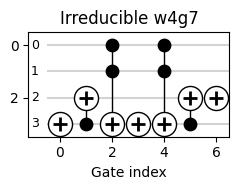


Sample hardest circuit:
  Gates: [([], 0), ([0], 2), ([1, 3], 0), ([], 0), ([1, 3], 0), ([0], 2), ([], 2)]


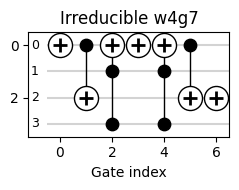


Sample hardest circuit:
  Gates: [([], 1), ([1], 3), ([0, 2], 1), ([], 1), ([0, 2], 1), ([1], 3), ([], 3)]


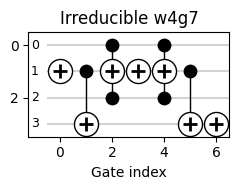


Sample hardest circuit:
  Gates: [([], 2), ([2], 3), ([0, 1], 2), ([], 2), ([0, 1], 2), ([2], 3), ([], 3)]


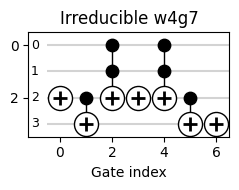


Sample hardest circuit:
  Gates: [([], 0), ([0], 3), ([1, 2], 0), ([], 0), ([1, 2], 0), ([0], 3), ([], 3)]


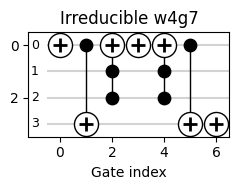


Sample hardest circuit:
  Gates: [([2], 0), ([1, 3], 2), ([], 2), ([1, 3], 2), ([2], 0), ([], 0), ([], 2)]


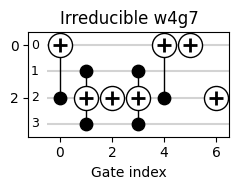


Sample hardest circuit:
  Gates: [([3], 0), ([1, 2], 3), ([], 3), ([1, 2], 3), ([3], 0), ([], 0), ([], 3)]


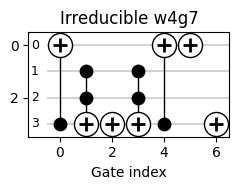


Sample hardest circuit:
  Gates: [([1], 0), ([2, 3], 1), ([], 1), ([2, 3], 1), ([1], 0), ([], 0), ([], 1)]


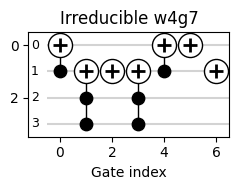


Sample hardest circuit:
  Gates: [([2], 1), ([0, 3], 2), ([], 2), ([0, 3], 2), ([2], 1), ([], 1), ([], 2)]


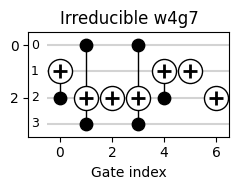


Sample hardest circuit:
  Gates: [([3], 1), ([0, 2], 3), ([], 3), ([0, 2], 3), ([3], 1), ([], 1), ([], 3)]


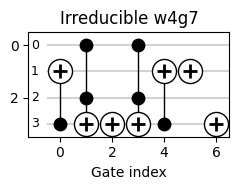


Sample hardest circuit:
  Gates: [([0], 1), ([2, 3], 0), ([], 0), ([2, 3], 0), ([0], 1), ([], 1), ([], 0)]


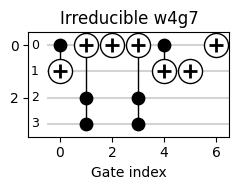


Sample hardest circuit:
  Gates: [([1], 2), ([0, 3], 1), ([], 1), ([0, 3], 1), ([1], 2), ([], 2), ([], 1)]


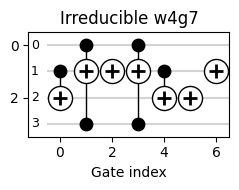


Sample hardest circuit:
  Gates: [([3], 2), ([0, 1], 3), ([], 3), ([0, 1], 3), ([3], 2), ([], 2), ([], 3)]


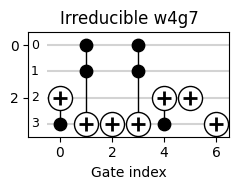


Sample hardest circuit:
  Gates: [([0], 2), ([1, 3], 0), ([], 0), ([1, 3], 0), ([0], 2), ([], 2), ([], 0)]


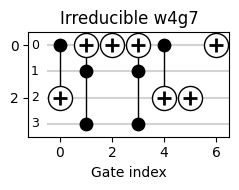


Sample hardest circuit:
  Gates: [([1], 3), ([0, 2], 1), ([], 1), ([0, 2], 1), ([1], 3), ([], 3), ([], 1)]


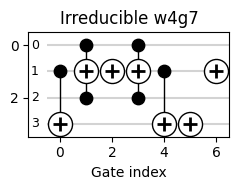


Sample hardest circuit:
  Gates: [([2], 3), ([0, 1], 2), ([], 2), ([0, 1], 2), ([2], 3), ([], 3), ([], 2)]


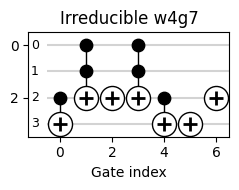


Sample hardest circuit:
  Gates: [([0], 3), ([1, 2], 0), ([], 0), ([1, 2], 0), ([0], 3), ([], 3), ([], 0)]


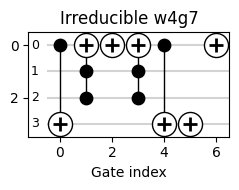


Sample hardest circuit:
  Gates: [([1, 3], 2), ([], 2), ([1, 3], 2), ([2], 0), ([], 0), ([], 2), ([2], 0)]


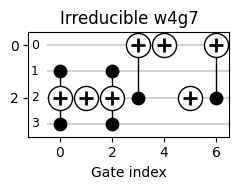


Sample hardest circuit:
  Gates: [([1, 2], 3), ([], 3), ([1, 2], 3), ([3], 0), ([], 0), ([], 3), ([3], 0)]


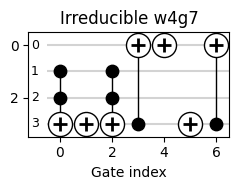


Sample hardest circuit:
  Gates: [([2, 3], 1), ([], 1), ([2, 3], 1), ([1], 0), ([], 0), ([], 1), ([1], 0)]


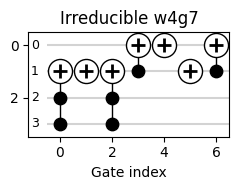


Sample hardest circuit:
  Gates: [([0, 3], 2), ([], 2), ([0, 3], 2), ([2], 1), ([], 1), ([], 2), ([2], 1)]


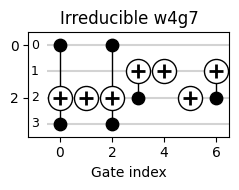


Sample hardest circuit:
  Gates: [([0, 2], 3), ([], 3), ([0, 2], 3), ([3], 1), ([], 1), ([], 3), ([3], 1)]


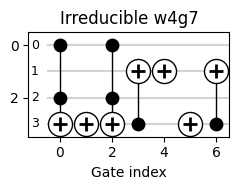


Sample hardest circuit:
  Gates: [([2, 3], 0), ([], 0), ([2, 3], 0), ([0], 1), ([], 1), ([], 0), ([0], 1)]


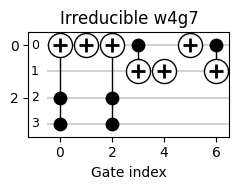


Sample hardest circuit:
  Gates: [([0, 3], 1), ([], 1), ([0, 3], 1), ([1], 2), ([], 2), ([], 1), ([1], 2)]


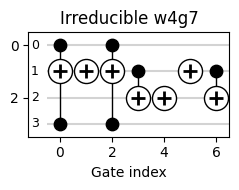


Sample hardest circuit:
  Gates: [([0, 1], 3), ([], 3), ([0, 1], 3), ([3], 2), ([], 2), ([], 3), ([3], 2)]


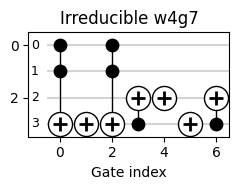


Sample hardest circuit:
  Gates: [([1, 3], 0), ([], 0), ([1, 3], 0), ([0], 2), ([], 2), ([], 0), ([0], 2)]


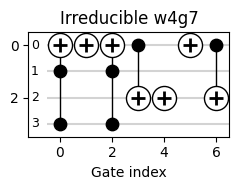


Sample hardest circuit:
  Gates: [([0, 2], 1), ([], 1), ([0, 2], 1), ([1], 3), ([], 3), ([], 1), ([1], 3)]


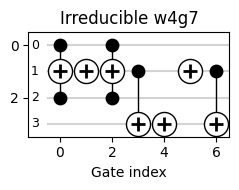


Sample hardest circuit:
  Gates: [([0, 1], 2), ([], 2), ([0, 1], 2), ([2], 3), ([], 3), ([], 2), ([2], 3)]


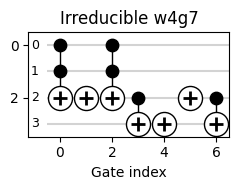


Sample hardest circuit:
  Gates: [([1, 2], 0), ([], 0), ([1, 2], 0), ([0], 3), ([], 3), ([], 0), ([0], 3)]


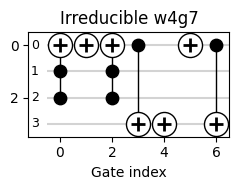


Sample hardest circuit:
  Gates: [([], 2), ([1, 3], 2), ([2], 0), ([], 0), ([], 2), ([2], 0), ([1, 3], 2)]


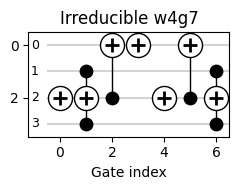


Sample hardest circuit:
  Gates: [([], 3), ([1, 2], 3), ([3], 0), ([], 0), ([], 3), ([3], 0), ([1, 2], 3)]


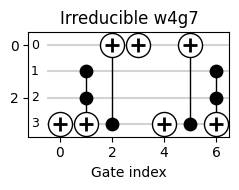


Sample hardest circuit:
  Gates: [([], 1), ([2, 3], 1), ([1], 0), ([], 0), ([], 1), ([1], 0), ([2, 3], 1)]


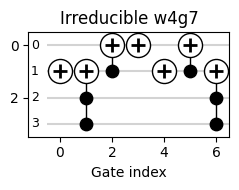


Sample hardest circuit:
  Gates: [([], 2), ([0, 3], 2), ([2], 1), ([], 1), ([], 2), ([2], 1), ([0, 3], 2)]


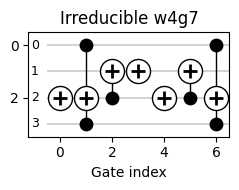


Sample hardest circuit:
  Gates: [([], 3), ([0, 2], 3), ([3], 1), ([], 1), ([], 3), ([3], 1), ([0, 2], 3)]


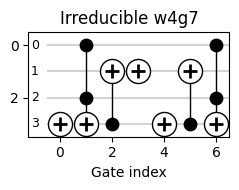


Sample hardest circuit:
  Gates: [([], 0), ([2, 3], 0), ([0], 1), ([], 1), ([], 0), ([0], 1), ([2, 3], 0)]


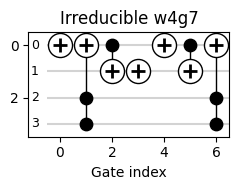


Sample hardest circuit:
  Gates: [([], 1), ([0, 3], 1), ([1], 2), ([], 2), ([], 1), ([1], 2), ([0, 3], 1)]


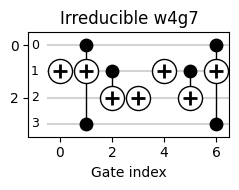


Sample hardest circuit:
  Gates: [([], 3), ([0, 1], 3), ([3], 2), ([], 2), ([], 3), ([3], 2), ([0, 1], 3)]


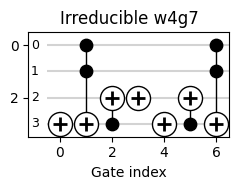


Sample hardest circuit:
  Gates: [([], 0), ([1, 3], 0), ([0], 2), ([], 2), ([], 0), ([0], 2), ([1, 3], 0)]


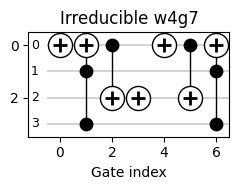


Sample hardest circuit:
  Gates: [([], 1), ([0, 2], 1), ([1], 3), ([], 3), ([], 1), ([1], 3), ([0, 2], 1)]


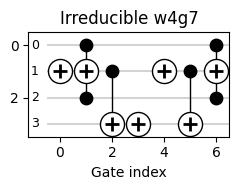


Sample hardest circuit:
  Gates: [([], 2), ([0, 1], 2), ([2], 3), ([], 3), ([], 2), ([2], 3), ([0, 1], 2)]


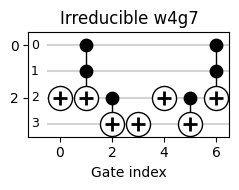


Sample hardest circuit:
  Gates: [([], 0), ([1, 2], 0), ([0], 3), ([], 3), ([], 0), ([0], 3), ([1, 2], 0)]


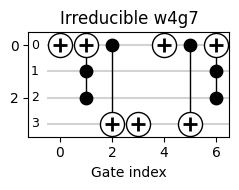


Sample hardest circuit:
  Gates: [([1, 3], 2), ([2], 0), ([], 0), ([], 2), ([2], 0), ([1, 3], 2), ([], 2)]


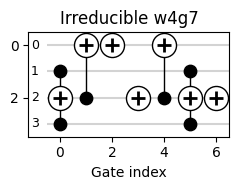


Sample hardest circuit:
  Gates: [([1, 2], 3), ([3], 0), ([], 0), ([], 3), ([3], 0), ([1, 2], 3), ([], 3)]


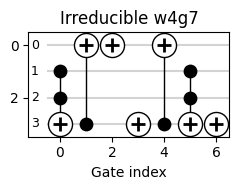

In [ ]:
irreducible = MOCK / 'irreducible_w4g7.pickle'
if irreducible.exists():
    with open(irreducible, 'rb') as f:
        hardest = pickle.load(f)
    
    print(f'Type: {type(hardest[0]).__name__ if hardest else "?"}')
    
    if hardest:
        i = 0
        for c in hardest:
            print(f'\nSample hardest circuit:')
            print(f'  Gates: {c.gates()}')
            draw_mct_circuit(c, 'Irreducible w4g7')
            i += 1
            if i >= 50:
                break
else:
    print('not found')